In [3]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.linalg import norm

from sfno.utils import get_seed
from sfno.pipeline import *
from sfno.visualizations import *
from sfno.sfno import SFNO
from sfno.finetune import OutConvFT
from torch.utils.data import DataLoader

get_seed(42, printout=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype = torch.float64
torch.set_default_dtype(dtype)


In [4]:
n = 256
Ntest = 16

TEST_PATH = os.path.join(
    DATA_PATH, f"fnodata_extra_fp64_{n}x{n}_N{Ntest}_v1e-3_T50_steps100_alpha2.5_tau7.pt"
)

batch_size = 1

epochs = 10
learning_rate = 0.01


T = 10
T_out = 40
fields = ["vorticity", "stream", "residual", "vorticity_t"]
fs = "vorticity"

modes = 12
modes_t = 5
width = 20
beta = 1e-2

model_name = (
    f"sfno_fnodata_ep{epochs}"
    + f"_in{T}_out{T_out}"
    + f"_b{beta:.0e}.pt".replace("e-0", "e-").replace("e+0", "e")
)

path_model = os.path.join(MODEL_PATH, model_name)
print(model_name)

sfno_fnodata_ep10_in10_out40_b1e-2.pt


In [5]:
test_dataset = BochnerDataset(datapath=TEST_PATH, 
                              fields=fields,
                              n_samples=Ntest,
                              steps=T,
                              out_steps=T_out,
                              T_start=30,
                              dtype=dtype,
                              train=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [25]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width, beta, output_steps=T_out).to(device)
print(get_num_params(model))

model.load_state_dict(torch.load(path_model))
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)
preds = []
gt_solns = []
gt_inps = []
test_l2_all = []
T_start = []


with torch.no_grad():
    model.eval()
    for i, (inp, out) in enumerate(test_loader):
        x, y = inp[fs].to(device), out[fs].to(device)
        pred = model(x, out_steps=T_out)

        preds.append(pred)
        gt_inps.append(x)
        gt_solns.append(y)
        tmp = (out["time_steps"][:, 0]*0.2+30).item()
        T_start.append(tmp)

        test_l2 = loss_func(pred, y).item()
        test_l2_all.append(test_l2)

preds = torch.cat(preds, dim=0)
gt_inps = torch.cat(gt_inps, dim=0)
gt_solns = torch.cat(gt_solns, dim=0)
print(f"Test L2 on {n}x{n}: {np.mean(test_l2_all):.5e}")

9245131
Test L2 on 256x256: 9.77389e-03


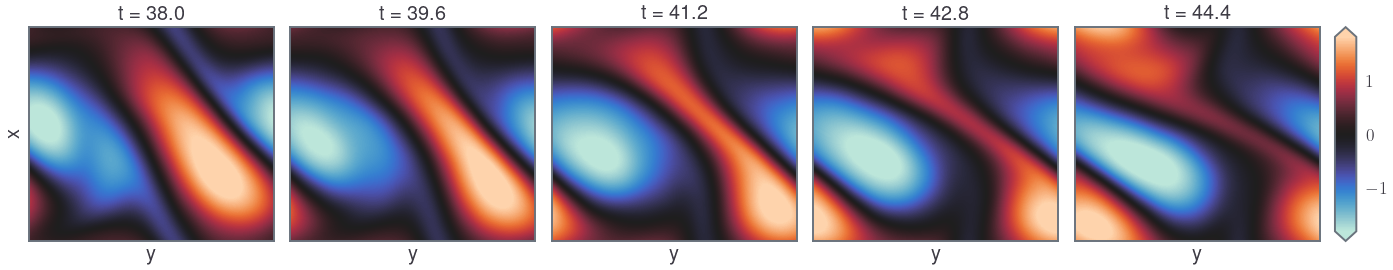

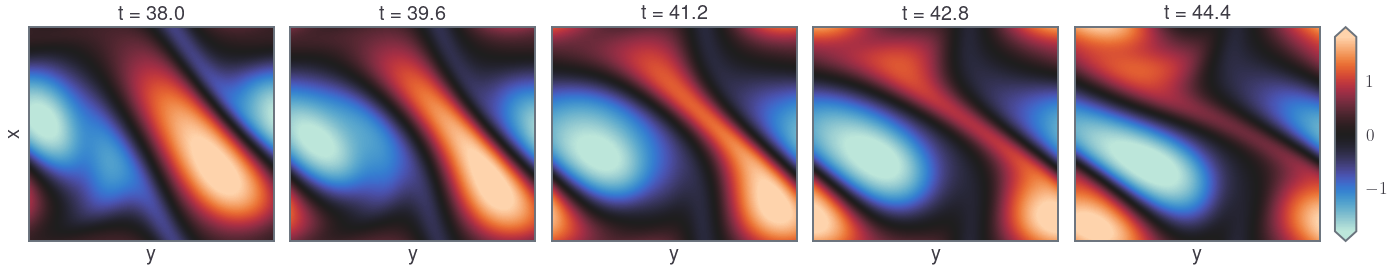

In [7]:
idx = 1

plot_contour_trajectory(preds[idx], num_snapshots=5, T_start=T_start[idx], dt=0.2)
plot_contour_trajectory(gt_solns[idx], num_snapshots=5, T_start=T_start[idx], dt=0.2)

In [8]:
sample = test_dataset.__getitem__(idx = idx, start_steps=30)
vort_inp_gt, vort_out_gt = sample[0]['vorticity'], sample[1]['vorticity']
stream_inp, stream_out = sample[0]['stream'], sample[1]['stream']
vort_inp_gt = vort_inp_gt.unsqueeze(0).to(device)
vort_out_gt = vort_out_gt.unsqueeze(0).to(device)


f_true = lambda x, y: 0.1 * (
    torch.sin(2 * math.pi * (x + y)) + torch.cos(2 * math.pi * (x + y))
)
grid = torch.linspace(0, 1, n+1)[0:-1]

X, Y = torch.meshgrid(grid, grid, indexing="ij")
f = f_true(X, Y)[None, ...].to(device)

model.eval()
model.add_latent_hook("r")

with torch.no_grad():
    preds_no = model(vort_inp_gt, out_steps=T_out)
    preds_no = preds_no.detach()
print(f"{loss_func(preds_no, vort_out_gt).item():.5e}")

v_latent = model.latent_tensors["r"]

8.20053e-03


In [30]:
res_loss_setting = {
    "n_grid": n,
    "relative": False,
    "time_average": True,
    "freq_cutoff": n // 2 + 1,
    "alpha": 10**(-3/2),
    "norm_order": -1,
}
l2_loss_setting = {
    "n_grid": n,
    "relative": True,
    "time_average": True,
    "freq_cutoff": n // 2 + 1,
}

l2diff = SobolevLoss(**l2_loss_setting)
ResHm1Loss = SobolevLoss(**res_loss_setting)

modes_orig = (modes, modes, modes_t)
modes_ft = (64, 64, 6)
ft_kws = {"n_grid": n, 
          "dt": 1e-6,
          "delta": 1,
          "diam": 1,
          "finetune": True,
          "bdf_weight": (0.5, 0.5),
          }

qft = OutConvFT(*modes_orig, **ft_kws)
qft._update_spectral_conv_weights(*modes_ft, device=device, model=model.q)
qft.to(device).to(dtype)
optimizer = torch.optim.Adam([
            {'params': qft.conv.bias, 'lr': 2e-1},
            {'params': qft.conv.weight, 'lr': 1e-4},
        ])

The fine-tuning process will first get closer to the ground truth (getting from `8.20053e-03` down to `4e-3`), then diverting away, and getting closer to the true solution that minimizes the PDE residual in the dual norm.

In [32]:
l2diff_ft_gt = []
residual_hm1norms = []

num_iter = 50

with tqdm(total=num_iter) as pbar:
    for i in range(num_iter):
        qft.train()

        def closure():
            optimizer.zero_grad()
            preds_ft_all = qft(v_latent, vort_inp_gt, f, out_steps=T_out)
            res_ft_new = preds_ft_all["residual"]
            loss = ResHm1Loss(res_ft_new)
            loss.backward(retain_graph=True)
            return loss

        preds_ft_all = qft(v_latent, vort_inp_gt, f, out_steps=T_out)
        preds_ft = preds_ft_all["w"]
        res_ft = preds_ft_all["residual"]

        l2loss = l2diff(preds_ft, vort_out_gt)
        l2diff_ft = l2diff(preds_ft, preds_no)
        reshm1loss = ResHm1Loss(res_ft)

        optimizer.step(closure)
        optimizer.zero_grad()

        l2diff_ft_gt.append(l2loss.item())
        residual_hm1norms.append(reshm1loss.item())
        pbar.set_description(
            f"\|ft-gt\|: {l2loss.item():.3e} | \|no-ft\|: {l2diff_ft.item():.3e} | Res Hm1 : {reshm1loss.item():.3e}"
        )
        pbar.update()

\|ft-gt\|: 4.398e-03 | \|no-ft\|: 2.394e-03 | Res Hm1 : 2.679e-06: 100%|██████████| 50/50 [00:03<00:00, 16.18it/s]


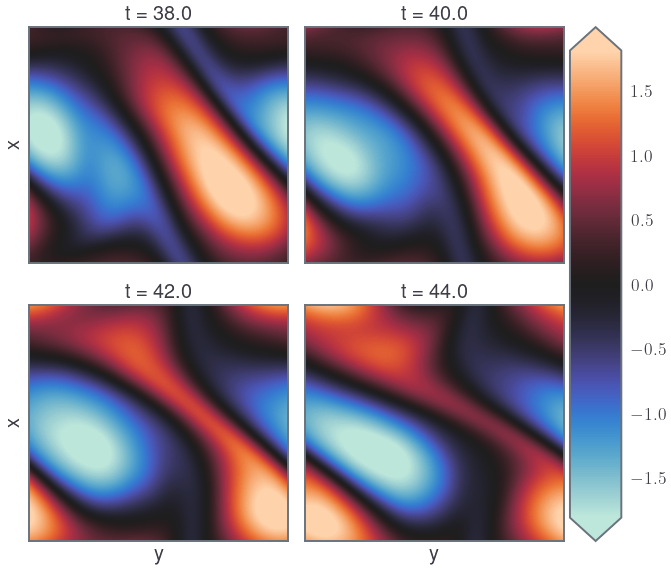

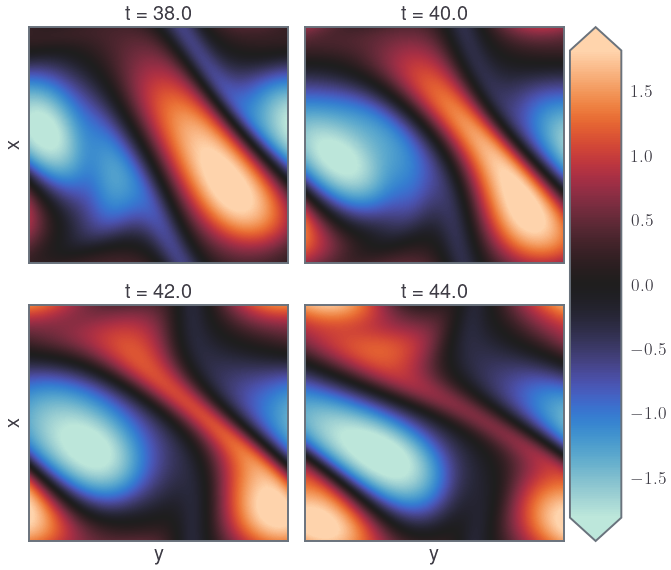

In [34]:
plot_contour_trajectory(preds_ft[0].detach().cpu(), num_snapshots=4, col_wrap=2, T_start=T_start[idx], dt=0.2)
plot_contour_trajectory(
    vort_out_gt[0].detach().cpu(), num_snapshots=4, col_wrap=2, T_start=T_start[idx], dt=0.2
)